In [2]:
import matplotlib.pyplot as plt
from matplotlib import cm
from pathlib import Path
#import seaborn as sns
import pandas as pd
import numpy as np
import itertools

In [3]:
folder = Path("results_synced/atlas_ratio/")
datasets = ["GunPoint", "Coffee"]
encoders = ["CNN_DFS"]
folds = 5

dfs = []
for dataset, encoder in itertools.product(datasets, encoders):
    paths = [folder /  f"EXP_ratio_{encoder}_{dataset}_f{f}.csv" for f in range(folds)]
    paths = [p for p in paths if p.exists()] 
    dfs.append(pd.concat([pd.read_csv(p) for p in paths]))
df = pd.concat(dfs, ignore_index=True)

In [4]:
ds = "Coffee"
df = df[df["dataset"] == ds]
df.groupby(["nsamp_tra", "nsamp_pre"]).mean()

/tmp/ipykernel_8095/2335806240.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df.groupby(["nsamp_tra", "nsamp_pre"]).mean()


pretrained  fold_number  random_state  batch_size  \
nsamp_tra nsamp_pre                                                      
683       0                 0.0          1.5           0.0       128.0   
          1941              1.0          0.0           0.0       128.0   
          1998              1.0          2.0           0.0       128.0   
          3882              1.0          0.0           0.0       128.0   
          3997              1.0          2.0           0.0       128.0   
          5825              1.0          0.0           0.0       128.0   
          5996              1.0          2.0           0.0       128.0   
          7766              1.0          0.0           0.0       128.0   
          7995              1.0          2.0           0.0       128.0   
          9709              1.0          0.0           0.0       128.0   
          9995              1.0          2.0           0.0       128.0   
1366      0                 0.0          1.5           0.0       128.0   
          1941              1.0          0.0           0.0       128.0   
          1998              1.0          2.0           0.0       128.0   
          3882              1.0          0.0           0.0       128.0   
          3997              1.0          2.0           0.0       128.0   
          5825              1.0          0.0           0.0       128.0   
          5996              1.0          2.0           0.0       128.0   
          7766              1.0          0.0           0.0       128.0   
          7995              1.0          2.0           0.0       128.0   
          9709              1.0          0.0           0.0       128.0   
          9995              1.0          2.0           0.0       128.0   
2050      0                 0.0          1.5           0.0       128.0   
          1941              1.0          0.0           0.0       128.0   
          1998              1.0          2.0           0.0       128.0   
          3882              1.0          0.0           0.0       128.0   
          3997              1.0          2.0           0.0       128.0   
          5825              1.0          0.0           0.0       128.0   
          5996              1.0          2.0           0.0       128.0   
          7766              1.0          0.0           0.0       128.0   
          7995              1.0          2.0           0.0       128.0   
          9709              1.0          0.0           0.0       128.0   
          9995              1.0          2.0           0.0       128.0   
2733      0                 0.0          1.5           0.0       128.0   
          1941              1.0          0.0           0.0       128.0   
          1998              1.0          2.0           0.0       128.0   
          3882              1.0          0.0           0.0       128.0   
          3997              1.0          2.0           0.0       128.0   
          5825              1.0          0.0           0.0       128.0   
          5996              1.0          2.0           0.0       128.0   
          7766              1.0          0.0           0.0       128.0   
          7995              1.0          2.0           0.0       128.0   
          9709              1.0          0.0           0.0       128.0   
          9995              1.0          2.0           0.0       128.0   
3417      0                 0.0          1.5           0.0       128.0   
          1941              1.0          0.0           0.0       128.0   
          1998              1.0          2.0           0.0       128.0   
          3882              1.0          0.0           0.0       128.0   
          3997              1.0          2.0           0.0       128.0   
          5825              1.0          0.0           0.0       128.0   
          5996              1.0          2.0           0.0       128.0   
          7766              1.0          0.0           0.0       128.0   
          7995           

In [5]:

cols = [c for c in df.columns if ("target_test" in c) or (("pretrain_val" in c) )]
xd0 = df[df["pretrained"] == False].groupby(["nsamp_tra"])[cols].mean()
xd1 = df.groupby(["nsamp_tra", "nsamp_pre"])[cols].max()
xd2 = df.groupby(["nsamp_tra", "nsamp_pre"])[cols].std()
print(df["nsamp_pre"].unique())
xd0

[   0 1941 3882 5825 7766 9709 1998 3997 5996 7995 9995]


,target_test_acc,target_test_f1,target_test_auroc,pretrain_val_acc,pretrain_val_f1,pretrain_val_auroc
nsamp_tra,,,,,,
683,0.447166,0.447166,0.441998,NaN,NaN,NaN
1366,0.437514,0.437514,0.378633,NaN,NaN,NaN
2050,0.520556,0.520556,0.507801,NaN,NaN,NaN
2733,0.504819,0.504819,0.496434,NaN,NaN,NaN
3417,0.527400,0.527400,0.503846,NaN,NaN,NaN


In [6]:
xd1.columns = [c + "_mean" for c in xd1.columns]
xd2.columns = [c + "_std" for c in xd2.columns]
xd = pd.concat([xd1, xd2], axis=1).reset_index()
xd.replace(np.NaN, 0, inplace=True)
xd1

target_test_acc_mean  target_test_f1_mean  \
nsamp_tra nsamp_pre                                              
683       0                      0.456723             0.456723   
          1941                   0.418496             0.418496   
          1998                   0.456723             0.456723   
          3882                   0.418496             0.418496   
          3997                   0.456723             0.456723   
          5825                   0.464735             0.464735   
          5996                   0.469179             0.469179   
          7766                   0.442786             0.442786   
          7995                   0.470137             0.470137   
          9709                   0.462101             0.462101   
          9995                   0.456723             0.456723   
1366      0                      0.460053             0.460053   
          1941                   0.476441             0.476441   
          1998                   0.463430             0.463430   
          3882                   0.457711             0.457711   
          3997                   0.460556             0.460556   
          5825                   0.464442             0.464442   
          5996                   0.521878             0.521878   
          7766                   0.491074             0.491074   
          7995                   0.476525             0.476525   
          9709                   0.478197             0.478197   
          9995                   0.520281             0.520281   
2050      0                      0.578870             0.578870   
          1941                   0.530290             0.530290   
          1998                   0.517087             0.517087   
          3882                   0.499268             0.499268   
          3997                   0.545193             0.545193   
          5825                   0.623354             0.623354   
          5996                   0.575854             0.575854   
          7766                   0.439274             0.439274   
          7995                   0.532418             0.532418   
          9709                   0.537313             0.537313   
          9995                   0.564037             0.564037   
2733      0                      0.579163             0.579163   
          1941                   0.515364             0.515364   
          1998                   0.514532             0.514532   
          3882                   0.577700             0.577700   
          3997                   0.709358             0.709358   
          5825                   0.546386             0.546386   
          5996                   0.592462             0.592462   
          7766                   0.553702             0.553702   
          7995                   0.638454             0.638454   
          9709                   0.575651             0.575651   
          9995                   0.493772             0.493772   
3417      0                      0.537899             0.537899   
          1941                   0.505121             0.505121   
          1998                   0.496646             0.496646   
          3882                   0.466491             0.466491   
          3997                   0.519323             0.519323   
          5825                   0.544922             0.544922   
          5996                   0.538486             0.538486   
          7766                   0.463272             0.463272   
          7995                   0.552220             0.552220   
          9709                   0.538191             0.538191   
          9995                   0.680294             0.680294   

                     target_test_auroc_mean  pretrain_val_acc_mean  \
nsamp_tra nsamp_pre                                                  
683       0                        0.479309                    NaN   
          1941                     0.465554     

Text(0, 0.5, 'f1')

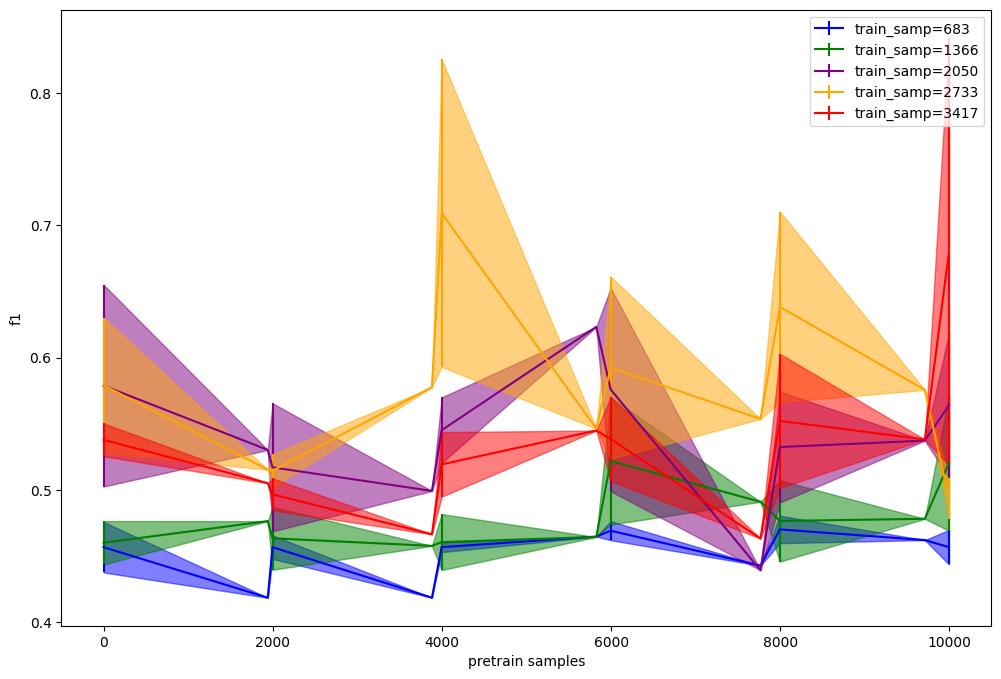

In [7]:
df: pd.DataFrame = xd

metric = "f1"

colors = ["blue", "green", "purple", "orange", "red"]
fig, ax = plt.subplots(figsize=[12,8])#plt.subplots(subplot_kw={"projection": "3d"})
for i, (nsamp, dfg) in enumerate(df.groupby(df["nsamp_tra"])):
    ax.errorbar(dfg["nsamp_pre"], dfg[f"target_test_{metric}_mean"], yerr=dfg[f"target_test_{metric}_std"], 
                label=f'train_samp={dfg["nsamp_tra"].unique()[0]}', c=colors[i])
    ax.fill_between(dfg["nsamp_pre"], y1=dfg[f"target_test_{metric}_mean"]+dfg[f"target_test_{metric}_std"], 
        y2=dfg[f"target_test_{metric}_mean"]-dfg[f"target_test_{metric}_std"], alpha = 0.5, color=colors[i])
plt.legend()
plt.xlabel("pretrain samples")
plt.ylabel(metric)

In [80]:
df: pd.DataFrame = dfs["ratio"]
cols = [c for c in df.columns if ("target_test" in c) and ("nepochs" not in c)]
print(df.groupby("nframes_pre")["dataset"].count())
xd = df.groupby("nframes_pre")[cols].mean(numeric_only=True)
xd.set_index(pd.Series(name="ratio pretrain/train", data=[0,1,2,3], dtype=int), inplace=True)
xd

TypeError: list indices must be integers or slices, not str

<AxesSubplot: xlabel='ratio pretrain/train'>

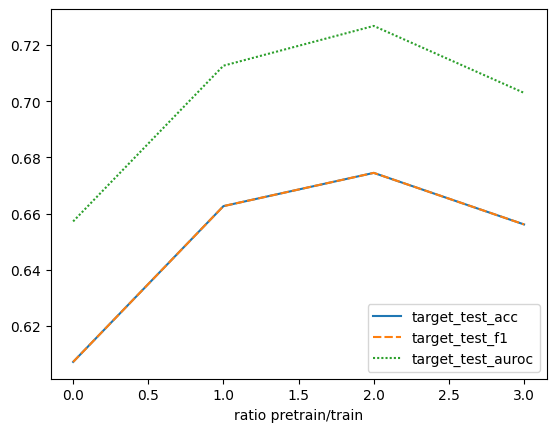

In [60]:
sns.lineplot(xd)

In [53]:
df = pd.read_csv("results/results.csv")
df["lab_shifts"] = df["lab_shifts"].str.slice(start=1,stop=-1).astype("category")
df

,dataset,fold_number,decoder,seed_sts,seed_label,batch_size,window_size,lab_shifts,nframes_tra,nframes_pre,...,aux_nepochs,pre_val_acc,pre_val_f1,pre_val_auroc,pre_test_acc,pre_test_f1,pre_test_auroc,pre_best_model,pre_train_csv,pre_nepochs
0,GunPoint,0,CNN,0,0,128,5,0,10000,40000,...,9,0.838825,0.838825,0.852924,0.646570,0.646570,0.714243,training/auto/0_0_2023-02-01_11-26/logs/pre/ch...,training/auto/0_0_2023-02-01_11-26/logs/pre/me...,122
1,GunPoint,0,CNN,0,0,128,5,0,10000,40000,...,6,0.841496,0.841496,0.857805,0.636455,0.636455,0.712427,training/auto/0_1_2023-02-01_11-37/logs/pre/ch...,training/auto/0_1_2023-02-01_11-37/logs/pre/me...,96
2,GunPoint,0,CNN,0,0,128,5,0.15,10000,40000,...,15,0.840012,0.840012,0.856416,0.637757,0.637757,0.714550,training/auto/0_2_2023-02-01_11-48/logs/pre/ch...,training/auto/0_2_2023-02-01_11-48/logs/pre/me...,100
3,GunPoint,0,CNN,0,0,128,5,0.15,10000,40000,...,7,0.831998,0.831998,0.852894,0.637957,0.637957,0.705994,training/auto/0_3_2023-02-01_11-59/logs/pre/ch...,training/auto/0_3_2023-02-01_11-59/logs/pre/me...,74


In [54]:
df.groupby("lab_shifts")[["def_test_f1", "pre_test_f1"]].mean()

,def_test_f1,pre_test_f1
lab_shifts,,
0,0.635103,0.641512
0.15,0.625538,0.637857


0.6320480704307556 0.6465698480606079


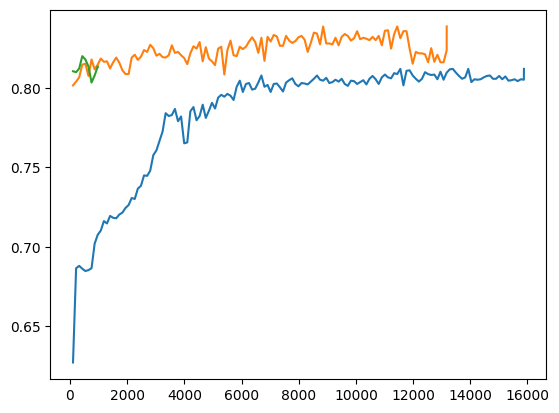

In [21]:
df_def = pd.read_csv("training/auto/0_0_2023-02-01_11-26/logs/def/metrics.csv")
df_aux = pd.read_csv("training/auto/0_0_2023-02-01_11-26/logs/aux/metrics.csv")
df_pre = pd.read_csv("training/auto/0_0_2023-02-01_11-26/logs/pre/metrics.csv")
df_def["val_f1"].dropna().plot()
df_pre["val_f1"].dropna().plot()
df_aux["val_f1"].dropna().plot()
print(df_def["test_f1"].max(), df_pre["test_f1"].max())

0.6381572484970093 0.636454701423645


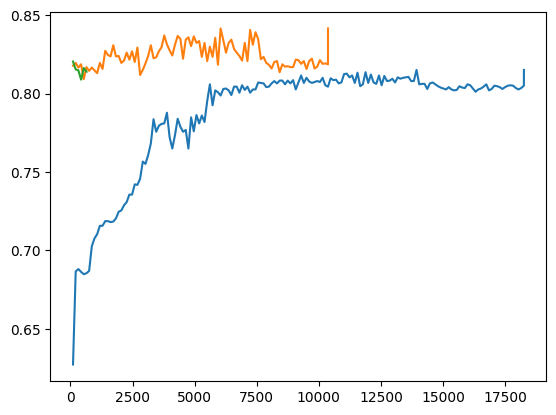

In [23]:
df_def = pd.read_csv("training/auto/0_1_2023-02-01_11-37/logs/def/metrics.csv")
df_aux = pd.read_csv("training/auto/0_1_2023-02-01_11-37/logs/aux/metrics.csv")
df_pre = pd.read_csv("training/auto/0_1_2023-02-01_11-37/logs/pre/metrics.csv")
df_def["val_f1"].dropna().plot()
df_pre["val_f1"].dropna().plot()
df_aux["val_f1"].dropna().plot()
print(df_def["test_f1"].max(), df_pre["test_f1"].max())